In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('testset.csv')
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [ ]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 non-null  int64  
 11   _tempm       100317 non-null  float64
 12   _thunder     100990 non-null  int64  
 13   _tornado     100990 non-null  int64  
 14   _vism        96562 non-null   float64
 15   _wdird       86235 non-null   float64
 16   _wdire       86235 non-null   object 
 17   _wgustm      1072 non-null    float64
 18   _wi

In [ ]:
df.isnull().sum()


datetime_utc         0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [ ]:
df['datetime_utc']=pd.to_datetime(df['datetime_utc'])
df['datetime_utc'].head()
df[' _tempm'].fillna(df[' _tempm'].mean(), inplace=True) # fill baris kosong di tempm
df = df[['datetime_utc',' _tempm' ]]
df.head()

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0


In [ ]:
df.isnull().sum()


datetime_utc    0
 _tempm         0
dtype: int64

In [ ]:
df['datetime_utc'] = df['datetime_utc'].dt.date

In [ ]:
df

,datetime_utc,_tempm
0,1996-11-01,30.0
1,1996-11-01,28.0
2,1996-11-01,24.0
3,1996-11-01,24.0
4,1996-11-01,23.0
...,...,...
100985,2017-04-24,34.0
100986,2017-04-24,38.0
100987,2017-04-24,36.0
100988,2017-04-24,32.0


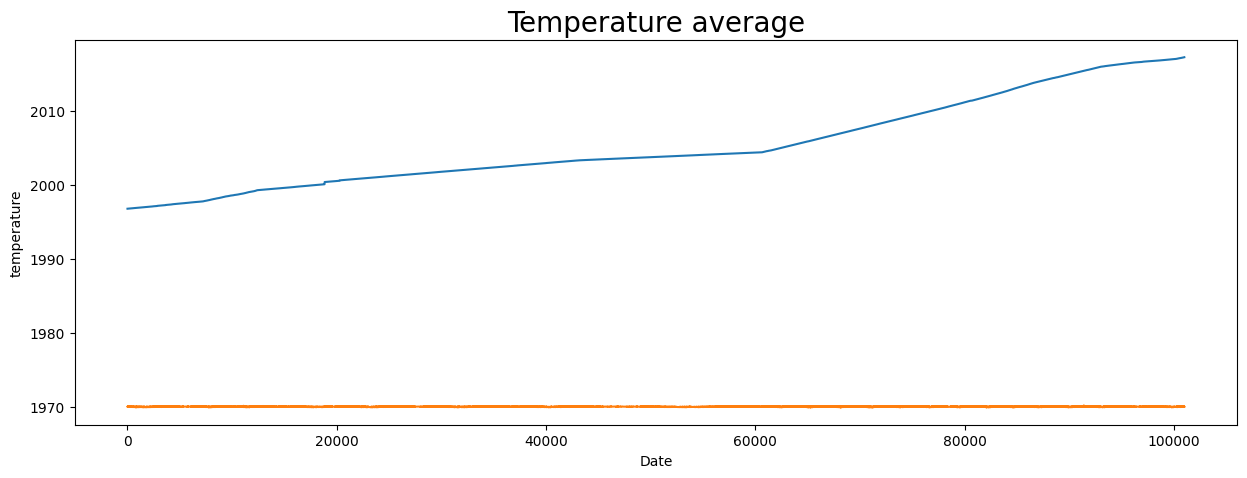

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.title('Temperature average',
          fontsize=20);
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [ ]:
# get data values
date = df['datetime_utc'].values
temp = df[' _tempm'].values

In [ ]:
date

array([datetime.date(1996, 11, 1), datetime.date(1996, 11, 1),
       datetime.date(1996, 11, 1), ..., datetime.date(2017, 4, 24),
       datetime.date(2017, 4, 24), datetime.date(2017, 4, 24)],
      dtype=object)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

80792 20198


In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [ ]:
max = df[' _tempm'].max()
print('Max value : ' )
print(max)

Max value : 
90.0


In [ ]:
min = df[' _tempm'].min()
print('Min value : ' )
print(min)

Min value : 
1.0


In [ ]:
x = (10/100)*(90.0-10) #MAE harus kurang dari 0.1 * (max-min).
x

8.0

In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [ ]:
history = model.fit(train_set,epochs=100, validation_data=test_set, callbacks=[callbacks])

Epoch 1/100
808/808 [==============================] - 136s 159ms/step - loss: 10.4151 - mae: 10.8979 - val_loss: 3.1619 - val_mae: 3.6327
Epoch 2/100
808/808 [==============================] - ETA: 0s - loss: 2.4349 - mae: 2.8953
MAE of the model < 10% of data scale
808/808 [==============================] - 128s 157ms/step - loss: 2.4349 - mae: 2.8953 - val_loss: 2.9194 - val_mae: 3.3826


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 60)          14880     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 46071 (179.96 KB)
Trainable params: 46071 (179.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


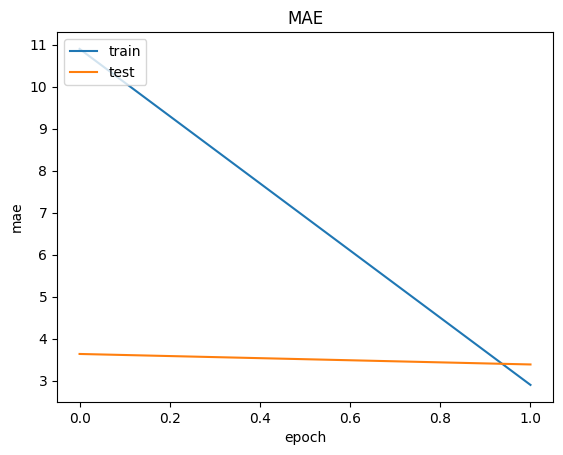

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

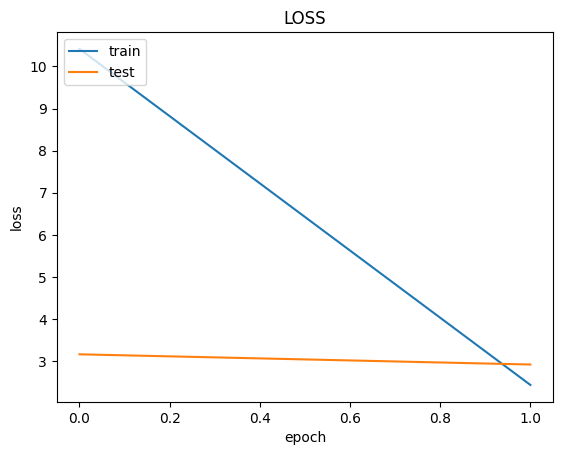

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("model.h5")

In [ ]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [ ]:
pip install tensorflowjs==3.9.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.15.0
    Uninstalling tensorflow-hub-0.15.0:
      Successfully uninstalled tensorflow-hub-0.15.0
  Attempting uninstall: tensorflowjs
    Found existing installation: tensorflowjs 4.15.0
    Uninstalling tensorflowjs-4.15.0:
      Successfully uninstalled tensorflowjs-4.15.0


In [ ]:
pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 59.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model.h5 /content/modeltfjs

2024-01-10 12:53:24.375002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


In [ ]:
!zip "/content/modeltfjs.zip" "/content/modeltfjs"

  adding: content/modeltfjs/ (stored 0%)
